In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [4]:
from os import name
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import math
import plotly.graph_objects as go
import scipy.optimize as sc

In [5]:
assets = ["AMD", "AMZN", "JPM"]
pf_data = pd.DataFrame()
for x in assets: 
    data = yf.download(x, start = '2020-01-01', end = '2024-01-01')["Close"]
    pf_data[x] = data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
print(pf_data.head())

                  AMD       AMZN         JPM
Date                                        
2020-01-02  49.099998  94.900497  141.089996
2020-01-03  48.599998  93.748497  138.339996
2020-01-06  48.389999  95.143997  138.229996
2020-01-07  48.250000  95.343002  135.880005
2020-01-08  47.830002  94.598503  136.940002


In [7]:
log_returns = np.log(pf_data/pf_data.shift(1)).dropna()
log_returns.head()

,AMD,AMZN,JPM
Date,,,
2020-01-03,-0.010236,-0.012213,-0.019684
2020-01-06,-0.004330,0.014776,-0.000795
2020-01-07,-0.002897,0.002089,-0.017147
2020-01-08,-0.008743,-0.007839,0.007771
2020-01-09,0.023555,0.004788,0.003645


In [8]:
average_price = pf_data.mean()
print("Average Price:")
print (average_price)

average_return = log_returns.mean()
print("\nAverage Return:")
print (average_return)

Average Price:
AMD      90.119970
AMZN    137.216247
JPM     133.535447
dtype: float64

Average Return:
AMD     0.001094
AMZN    0.000468
JPM     0.000186
dtype: float64


In [9]:
price_std_deviation = pf_data.std()
print ("Standard Deviation of Prices ")
print (price_std_deviation)

return_std_deviation = log_returns.std()
print ("\nStandard Deviation of Returns")
print (return_std_deviation)

Standard Deviation of Prices 
AMD     24.981102
AMZN    27.468805
JPM     22.376003
dtype: float64

Standard Deviation of Returns
AMD     0.033641
AMZN    0.023735
JPM     0.021684
dtype: float64


In [10]:
correlation_matrix = log_returns.corr()
print("Correlation Matrix of Returns")
print (correlation_matrix)

Correlation Matrix of Returns
           AMD      AMZN       JPM
AMD   1.000000  0.587198  0.330576
AMZN  0.587198  1.000000  0.272394
JPM   0.330576  0.272394  1.000000


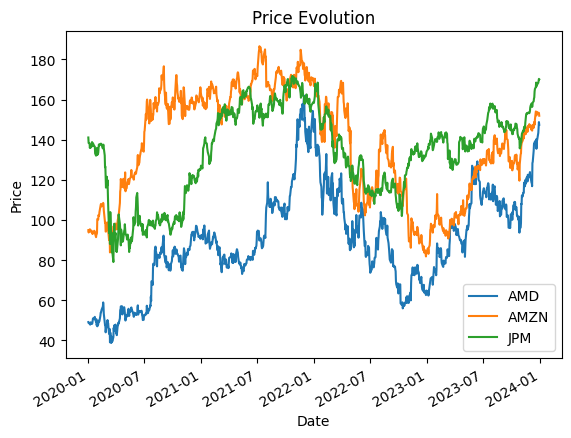

In [11]:
pf_data.plot(title = "Price Evolution")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

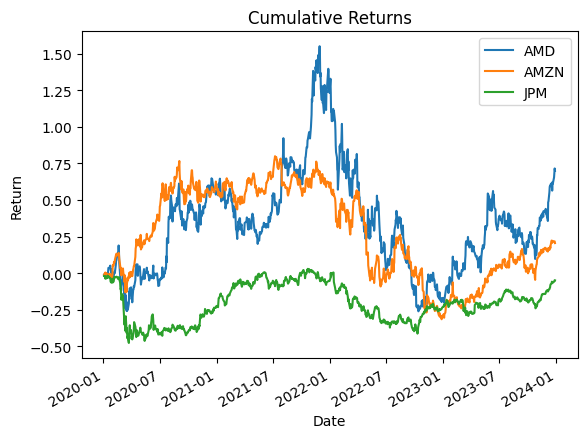

In [12]:
cumulative_returns = (1 + log_returns).cumprod() - 1
cumulative_returns.plot(title = "Cumulative Returns")
plt.xlabel ("Date")
plt.ylabel("Return")
plt.show()

In [13]:
expected_returns = log_returns.mean()
expected_returns

AMD     0.001094
AMZN    0.000468
JPM     0.000186
dtype: float64

In [14]:
covariance_matrix = log_returns.cov()
covariance_matrix

,AMD,AMZN,JPM
AMD,0.001132,0.000469,0.000241
AMZN,0.000469,0.000563,0.000140
JPM,0.000241,0.000140,0.000470


In [15]:
def portfolioPerformance(weights:np.array, expected_returns:np.array, covariance_matrix:np.matrix):
    returns = np.sum(expected_returns * weights) * 252
    std = np.sqrt(
        np.dot(weights.T, np.dot(covariance_matrix, weights))
    ) * np.sqrt(252)
    return returns, std

In [16]:
w_example = np.array([0.33, 0.33, 0.34])
eRet_example, vol_example = portfolioPerformance(weights=w_example, expected_returns = expected_returns, covariance_matrix=covariance_matrix)
print(eRet_example, vol_example)

0.1458544078340789 0.3278903639453347


In [17]:
def negativeSR(weights, expected_returns, covariance_matrix, rf:float = 0):
    pReturns, pStd = portfolioPerformance(weights, expected_returns, covariance_matrix)
    return - (pReturns - rf) / pStd

In [18]:
sr_negative_example = negativeSR(weights=w_example, expected_returns=expected_returns, covariance_matrix=covariance_matrix)
print(sr_negative_example)

-0.4448267587954963


In [19]:
def portfolioReturn(weights, expected_returns, covariance_matrix):
    return portfolioPerformance(weights, expected_returns, covariance_matrix)[0]

def portfolioVariance(weights, expected_returns, covariance_matrix):
    return portfolioPerformance(weights, expected_returns, covariance_matrix)[1]

In [20]:
mu_example = portfolioReturn(weights=w_example, expected_returns=expected_returns, covariance_matrix=covariance_matrix)
sigma_example = portfolioVariance(weights=w_example, expected_returns=expected_returns, covariance_matrix=covariance_matrix)
print(mu_example, sigma_example)

0.1458544078340789 0.3278903639453347


In [21]:
def minimizeVariance(expected_returns, covariance_matrix, constraintSet=(0, 1)):
    """Minimize the portfolio variance by altering the 
     weights/allocation of assets in the portfolio"""
    n = len(expected_returns)
    args = (expected_returns, covariance_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple(constraintSet for asset in range(n))
    result = sc.minimize(portfolioVariance, n * [1. / n], args=args,
                         method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [22]:
w_minvar = minimizeVariance(expected_returns=expected_returns, covariance_matrix=covariance_matrix)
print(w_minvar)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.2864478909251803
       x: [ 0.000e+00  4.382e-01  5.618e-01]
     nit: 5
     jac: [ 2.999e-01  2.865e-01  2.864e-01]
    nfev: 20
    njev: 5


In [23]:
def maxSR(expected_returns, covariance_matrix, rf=0, constraintSet=(0, 1)):
    "Minimize the negative SR, by altering the weights of the portfolio"
    n = len(expected_returns)
    args = (expected_returns, covariance_matrix, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(n))
    result = sc.minimize(negativeSR, n * [1. / n], args=args,
                         method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [24]:
w_sr = maxSR(expected_returns=expected_returns, covariance_matrix=covariance_matrix)
print(w_sr)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.5163420652162191
       x: [ 9.586e-01  4.143e-02  0.000e+00]
     nit: 7
     jac: [-2.488e-05  5.361e-04  2.363e-02]
    nfev: 29
    njev: 7


In [26]:
def efficientOpt(expected_returns, covariance_matrix, returnTarget, constraintSet=(0, 1)):
    """For each returnTarget, we want to optimise the portfolio for min variance"""
    n = len(expected_returns)
    args = (expected_returns, covariance_matrix)

    constraints = ({'type': 'eq', 'fun': lambda x: portfolioReturn(x, expected_returns, covariance_matrix) - returnTarget},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(n))
    effiportfolio = sc.minimize(portfolioVariance, n * [1. / n], args=args, method='SLSQP', bounds=bounds,
                         constraints=constraints)
    return effiportfolio

In [27]:
def calculatedResults(expected_returns, covariance_matrix, rf=0, constraintSet=(0, 1)):
    """Read in mean, cov matrix, and other financial information
        Output, Max SR , Min Volatility, efficient frontier """
    # Max Sharpe Ratio Portfolio
    maxSR_Portfolio = maxSR(expected_returns, covariance_matrix)
    maxSR_returns, maxSR_std = portfolioPerformance(maxSR_Portfolio['x'], expected_returns, covariance_matrix)
    maxSR_allocation = pd.DataFrame(maxSR_Portfolio['x'], index=expected_returns.index, columns=['allocation'])
    maxSR_allocation.allocation = [round(i * 100, 0) for i in maxSR_allocation.allocation]

    # Min Volatility Portfolio
    minVol_Portfolio = minimizeVariance(expected_returns, covariance_matrix)
    minVol_returns, minVol_std = portfolioPerformance(minVol_Portfolio['x'], expected_returns, covariance_matrix)
    minVol_allocation = pd.DataFrame(minVol_Portfolio['x'], index=expected_returns.index, columns=['allocation'])
    minVol_allocation.allocation = [round(i * 100, 0) for i in minVol_allocation.allocation]

    # Efficient Frontier
    efficientList = []
    targetReturns = np.linspace(minVol_returns, maxSR_returns*1.1, 20)
    for target in targetReturns:
        efficientList.append(efficientOpt(expected_returns, covariance_matrix, target)['fun'])

    maxSR_returns, maxSR_std = round(maxSR_returns * 100, 2), round(maxSR_std * 100, 2)
    minVol_returns, minVol_std = round(minVol_returns * 100, 2), round(minVol_std * 100, 2)      
    return maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList, targetReturns


In [28]:
maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation,\
      efficientList, targetReturns = calculatedResults(expected_returns=expected_returns, covariance_matrix=covariance_matrix)
print(maxSR_returns, maxSR_std, maxSR_allocation)
print(minVol_returns, minVol_std, minVol_allocation)

26.91 52.12       allocation
AMD         96.0
AMZN         4.0
JPM          0.0
7.81 28.64       allocation
AMD          0.0
AMZN        44.0
JPM         56.0


In [29]:
def simulate(stocks, expected_returns, covariance_matrix, n_sim, rf=0):
    n = len(expected_returns)
    simulated_ptf_return = []
    simulated_ptf_std = []
    simulated_sharpe_ratio = []
    w = np.zeros((n_sim, n))
    portfolio = pd.DataFrame()
    for i in np.arange(n_sim):
        weights = np.array(np.random.random(n))
        weights = weights / np.sum(weights)
        simulated_ptf_return.append(np.sum(weights * expected_returns) * 252)
        simulated_ptf_std.append(np.sqrt(
            np.dot(weights.T, np.dot(covariance_matrix, weights))) * np.sqrt(252))
        simulated_sharpe_ratio.append((simulated_ptf_return[i] - np.array(rf)) / simulated_ptf_std[i])
        w[i, :] = weights
    for i in range(n ):
        if i == 0:
            portfolio = pd.DataFrame({stocks[i]: w[:, i]})
        else:
            portfolio[stocks[i]] = w[:, i]
    portfolio['Return'] = simulated_ptf_return
    portfolio['Volatility'] = simulated_ptf_std
    portfolio['Sharpe Ratio'] = simulated_sharpe_ratio
    return portfolio

In [30]:
simulated_portfolios = simulate(stocks=assets, expected_returns = expected_returns, covariance_matrix = covariance_matrix, n_sim=20000)
simulated_portfolios

,AMD,AMZN,JPM,Return,Volatility,Sharpe Ratio
0,0.025169,0.491329,0.483503,0.087592,0.288684,0.303419
1,0.000269,0.354147,0.645584,0.072138,0.288768,0.249814
2,0.262226,0.371895,0.365880,0.133329,0.315319,0.422839
3,0.337633,0.271381,0.390986,0.143431,0.325994,0.439981
4,0.229681,0.422617,0.347702,0.129492,0.312653,0.414171
...,...,...,...,...,...,...
19995,0.378131,0.195327,0.426542,0.147286,0.332705,0.442693
19996,0.138739,0.258160,0.603101,0.096989,0.296113,0.327541
19997,0.368839,0.225518,0.405643,0.147308,0.331387,0.444519
19998,0.150299,0.386567,0.463135,0.108767,0.296499,0.366838


In [31]:
index = simulated_portfolios["Sharpe Ratio"].idxmax()
result = pd.DataFrame(simulated_portfolios.iloc[index])
result.columns = ['Max Sharpe Ratio Portfolio']
result

,Max Sharpe Ratio Portfolio
AMD,0.958298
AMZN,0.038083
JPM,0.003619
Return,0.268829
Volatility,0.520729
Sharpe Ratio,0.516255


In [49]:
index5 = simulated_portfolios["Return"].idxmax()
result5 = pd.DataFrame(simulated_portfolios.iloc[index5])
result5.columns = ['Max Return']
result5

,Max Return
AMD,0.987035
AMZN,0.002846
JPM,0.010119
Return,0.272897
Volatility,0.528896
Sharpe Ratio,0.515974


In [32]:
vol_maxSR = result.loc['Volatility', 'Max Sharpe Ratio Portfolio']
ret_maxSR = result.loc['Return', 'Max Sharpe Ratio Portfolio']

In [33]:
index2 = simulated_portfolios["Volatility"].idxmin()
result2 = pd.DataFrame(simulated_portfolios.iloc[index2])
result2.columns = ['Min Volatility Portfolio']
result2

,Min Volatility Portfolio
AMD,0.000815
AMZN,0.442869
JPM,0.556316
Return,0.078574
Volatility,0.286468
Sharpe Ratio,0.274284


In [48]:
index4 = simulated_portfolios["Volatility"].idxmax()
result4 = pd.DataFrame(simulated_portfolios.iloc[index4])
result4.columns = ['Max Volatility']
result4

,Max Volatility
AMD,0.987035
AMZN,0.002846
JPM,0.010119
Return,0.272897
Volatility,0.528896
Sharpe Ratio,0.515974


In [34]:
vol_minVol = result2.loc['Volatility', 'Min Volatility Portfolio']
ret_minVol = result2.loc['Return', 'Min Volatility Portfolio']

In [35]:
average_returns = log_returns.mean()
std_returns = log_returns.std()

In [61]:
average_returns_data = {'AMD': 0.001094, 'AMZN': 0.000468, 'JPM': 0.000186}
volatilities_data = {'AMD': 0.033641, 'AMZN': 0.023735, 'JPM': 0.021684}

In [62]:
df_average_returns = pd.Series(average_returns_data, name='Average Return')
df_volatilities = pd.Series(volatilities_data, name='Volatility')

In [63]:
rf = 0
x2 = [0, float(maxSR_std)]
y2 = [rf, float(maxSR_returns)]
slope, intercept = np.polyfit(x2,y2,1)
print(slope)

0.5163085188027627


In [64]:
range = np.arange(0, 0.8, 0.001)
rangey = slope * range + intercept

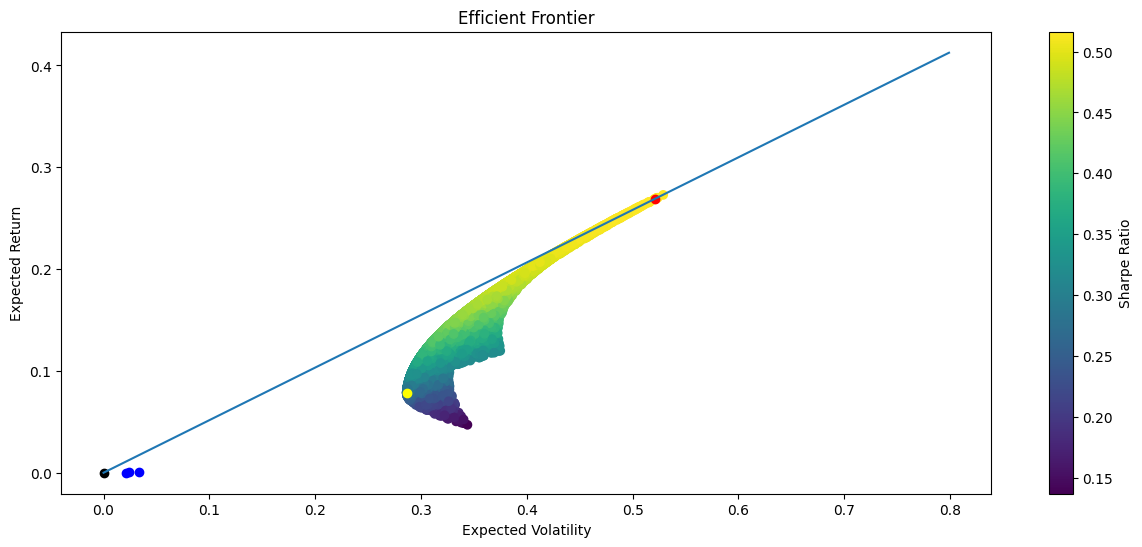

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,6))
plt.scatter(x = simulated_portfolios["Volatility"], y = simulated_portfolios["Return"], c = simulated_portfolios["Sharpe Ratio"])
plt.plot(range, rangey)
plt.colorbar(label = 'Sharpe Ratio')
plt.scatter(0, rf, c = "black")
plt.xlabel("Expected Volatility")
plt.ylabel("Expected Return")
plt.scatter(df_volatilities, df_average_returns, c='blue', marker='o')
plt.scatter(vol_maxSR, ret_maxSR, c = "red")
plt.scatter(vol_minVol, ret_minVol, c = "yellow")
plt.title("Efficient Frontier");

In [45]:
texte = "For the 3 assets, the average return is pretty low even though the stanfard deviation of these assets' return is close to 2 and 3%"
print (texte)

For the 3 assets, the average return is pretty low even though the stanfard deviation of these assets' return is close to 2 and 3%


In [46]:
texte2 = "The 3 assets have a positive correlation, however the correlation between AMD and AMZN is more significant than the other correlations. So the 3 stocks will tend to move in the same way. This is why it is not risky to invest in the 3 at the same time because they could react in the same way to the market"
print (texte2)

The 3 assets have a positive correlation, however the correlation between AMD and AMZN is more significant than the other correlations. So the 3 stocks will tend to move in the same way. This is why it is not risky to invest in the 3 at the same time because they could react in the same way to the market


In [51]:
texte3 = "Based on the calculations above, it's clear that to get a high return, the investor has to take risk. The allocation doesn't matter. The Max Sharpe Ratio Portfolio has a volatility close to the one of the Max Volatility Portfolio and the Min Volatility Portfolio has a high Volatility."
print(texte3)

Based on the calculations above, it's clear that to get a high return, the investor has to take risk. The allocation doesn't matter. The Max Sharpe Ratio Portfolio has a volatility close to the one of the Max Volatility Portfolio and the Min Volatility Portfolio has a high Volatility.


In [55]:
texte4 = "Moreover, concerning the Min Volatility, the conclusion of the optimization and the simulation for the Min Volatility, the results match, and it's the same for the allocation of the Max Sharpe Ratio Portfolio."
print (texte4)

Moreover, concerning the Min Volatility, the conclusion of the optimization and the simulation for the Min Volatility, the results match, and it's the same for the allocation of the Max Sharpe Ratio Portfolio.
